In [112]:
import warnings
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
import csv
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

## Loading an audio

In [80]:
warnings.filterwarnings("ignore")
audio_path = 'dataset/belfast/1.wav'
x, sr = librosa.load(audio_path)
print(sr)

22050


In [81]:
ipd.Audio(audio_path)

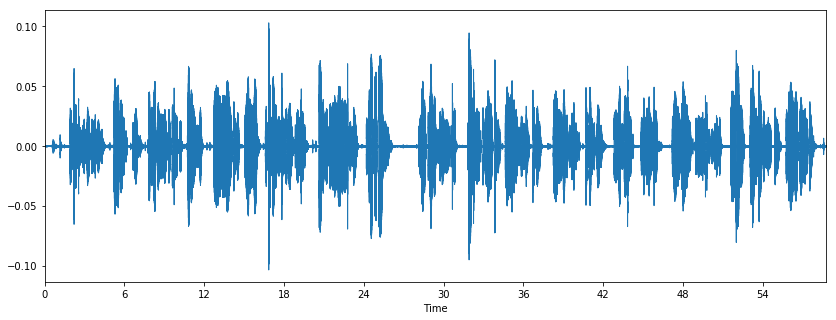

In [82]:
%matplotlib inline
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

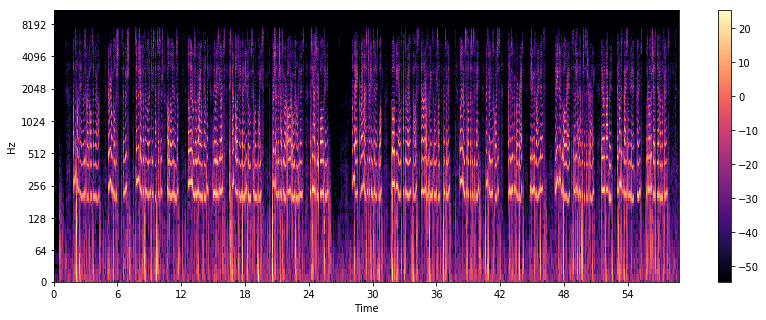

In [84]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Feature Extraction

(20, 2531)


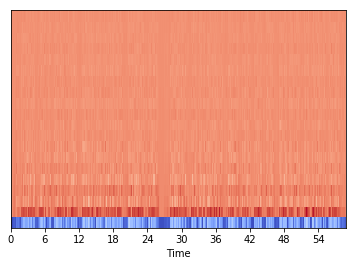

In [85]:
#MFCC
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [86]:
#Spectral Flux
spectral_flux = librosa.onset.onset_strength(y=x, sr=sr)
print(spectral_flux)
D = np.abs(librosa.stft(x))
times = librosa.times_like(D)
# plt.plot(times, 2 + spectral_flux / spectral_flux.max(), alpha=0.8, label='Mean (mel)')

[0.         0.         0.         ... 0.5288961  0.73161936 0.464897  ]


## Building the dataset

In [87]:
header = ''
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
print(header)

['mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


In [88]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
dialects = 'belfast bradford cambridge dublin leeds london newcastle cardiff liverpool'.split()
for g in dialects:
    for filename in os.listdir(f'./dataset/{g}'):
        audio = f'./dataset/{g}/{filename}'
        y, sr = librosa.load(audio)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f''
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())
    print(g)

belfast
bradford
cambridge
dublin
leeds
london
newcastle
cardiff
liverpool


## Creating the dataframe

In [97]:
data = pd.read_csv('data.csv')
data.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,-624.133972,92.906517,4.097229,32.264370,2.275501,3.509783,-6.406007,6.025269,1.168657,-1.445665,...,-2.331068,2.994455,0.793596,-0.996757,-3.860668,3.837088,-2.332046,-2.910211,2.054333,belfast
1,-377.066345,124.858101,0.103363,33.038155,10.887199,4.193736,5.855195,-0.363229,-4.630013,5.028852,...,-1.203855,5.105309,2.276420,2.902198,0.390548,4.058152,0.267058,-1.072543,1.142163,belfast
2,-625.159180,104.566574,-9.177590,34.545654,-9.988764,8.151351,-2.776427,1.582320,-0.185300,1.184052,...,-7.290379,3.021438,-1.500024,-2.243755,-2.962698,4.735775,-1.586903,1.864654,5.923014,belfast
3,-364.817780,90.733223,10.041720,37.706409,5.489851,7.551200,-0.636353,0.438687,3.456681,-0.615921,...,3.031095,2.978160,9.546766,3.464277,-0.839185,5.303529,-0.876556,-3.747692,-0.475310,belfast
4,-621.057983,105.175049,-4.323192,32.132053,-7.603986,8.402979,-1.165767,1.990026,1.383275,1.195854,...,-5.106633,2.509308,-0.917350,-2.640770,-2.139433,4.654262,-0.777256,2.191669,5.752567,belfast


In [96]:
dialect_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(dialect_list)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [109]:
data.describe()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,-381.779116,115.632575,-2.821518,43.016869,2.999963,12.822871,-8.847131,-0.746742,-4.653923,-2.455641,-1.621921,-1.312274,3.075177,-2.257174,5.358047,-5.159533,0.903882,-2.750334,-1.452036,-1.232287
std,83.684370,13.856956,15.088411,8.019931,9.930254,8.512471,7.610232,6.156364,5.266496,5.663403,5.084338,4.837336,4.128331,4.195286,4.718547,4.125416,3.558148,3.014129,2.780880,2.540637
min,-641.952393,69.347168,-48.330265,18.253445,-21.904736,-8.016874,-32.008045,-19.634277,-28.314642,-21.908682,-16.930475,-19.472330,-9.478283,-16.733381,-7.265416,-17.923958,-10.600650,-12.093921,-10.055735,-9.483578
25%,-433.223969,106.891773,-13.416759,37.980177,-3.884253,7.004837,-14.204420,-4.720536,-7.874927,-5.479033,-4.907986,-4.553310,0.738285,-4.976495,2.181630,-8.005936,-1.206939,-4.784654,-3.391708,-2.971866
50%,-357.805756,115.817505,-1.359513,43.001347,2.102069,11.805554,-8.463000,-0.199932,-4.326873,-1.561744,-1.217651,-1.393730,3.462148,-2.237794,5.478234,-5.367977,0.907818,-2.652900,-1.610514,-1.328613
75%,-317.872940,124.128811,7.474533,48.872175,10.794315,18.430907,-3.000265,3.807132,-1.348822,1.460034,1.642439,2.131271,5.966120,0.703064,8.731887,-2.399001,3.407146,-0.548582,0.225095,0.393269
max,-233.555878,155.284912,31.742620,68.046967,25.436390,41.090004,7.851963,13.710154,7.994925,11.439799,11.705025,12.546697,14.363324,10.819261,17.639257,11.398107,10.427183,5.037783,7.395306,7.589655


In [111]:
data.isnull().sum()

mfcc1     0
mfcc2     0
mfcc3     0
mfcc4     0
mfcc5     0
mfcc6     0
mfcc7     0
mfcc8     0
mfcc9     0
mfcc10    0
mfcc11    0
mfcc12    0
mfcc13    0
mfcc14    0
mfcc15    0
mfcc16    0
mfcc17    0
mfcc18    0
mfcc19    0
mfcc20    0
label     0
dtype: int64

In [98]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:,:-1], dtype = float))

## Model Building

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [100]:
#Logistic Regression
logistic_classifier = linear_model.logistic.LogisticRegression()
logistic_classifier.fit(X_train, y_train)
logistic_predictions = logistic_classifier.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("logistic accuracy = " + str(logistic_accuracy))

logistic accuracy = 0.8512396694214877


In [101]:
#SVM
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("svm accuracy = " + str(svm_accuracy))

svm accuracy = 0.9586776859504132


In [108]:
#KNN
knn_classifier = KNeighborsClassifier(n_neighbors = 3)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("knn accuracy = " + str(knn_accuracy))

knn accuracy = 0.9669421487603306


In [ ]:
#XGBoost
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
nc = labels.size
param = {
    'eta': 0.3, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': nc} 

steps = 20  # The number of training iterations
model = xgb.train(param, D_train, steps)
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
xgboost_accuracy = accuracy_score(y_test, best_preds)
print("XGBoost accuracy = " + str(xgboost_accuracy))